# Atuomated Feature Generation 
https://github.com/blue-yonder/tsfresh

In [1]:
# import sys
# sys.path.append('ts_fe/')

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from tqdm.autonotebook import tqdm

# импортируем необходимые функции из библиотеки
from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from src.utils import *

In [2]:
DATA_FOLDER = 'data/raw/UCI_HAR/'
INPUT_FOLDER_TRAIN = DATA_FOLDER + 'train/InertialSignals/'
INPUT_FOLDER_TEST = DATA_FOLDER + 'test/InertialSignals/'
LABELFILE_TRAIN = DATA_FOLDER + 'train/y_train.txt'
LABELFILE_TEST = DATA_FOLDER + 'test/y_test.txt'

train_signals, test_signals, train_labels, test_labels = read_data(
    input_folder_train=INPUT_FOLDER_TRAIN,
    input_folder_test=INPUT_FOLDER_TEST,
    labelfile_train=LABELFILE_TRAIN,
    labelfile_test=LABELFILE_TEST
)

train_signals, train_labels = randomize(train_signals, np.array(train_labels))
test_signals, test_labels = randomize(test_signals, np.array(test_labels))

In [3]:
train_signals.shape

(7352, 128, 9)

In [4]:
settings_efficient = settings.EfficientFCParameters()

In [5]:
def get_long_dfs(data):
    long_dfs = []
    for signal in range(0, 9):
        signal_df_long = pd.DataFrame(
            {
                0: data[:, :, signal].reshape(-1),
                1: np.arange(data.shape[0]).repeat(data.shape[1])
            }
        )
        long_dfs.append(signal_df_long)
    return long_dfs

def extract_tsfeatures(data, settings):
    long_dfs = get_long_dfs(data)
    signal_features = []
    for signal in tqdm(range(0, 9), leave=False):
        s_features = extract_features(
            long_dfs[signal], column_id=1, 
            impute_function=impute, 
            default_fc_parameters=settings_efficient,
            n_jobs=6,
            disable_progressbar=True,
            show_warnings=False
        )
        signal_features.append(s_features)
    
    signal_features_df = pd.concat(signal_features, axis=1)
    return signal_features_df

In [6]:
settings.MinimalFCParameters()

{'sum_values': None, 'median': None, 'mean': None, 'length': None, 'standard_deviation': None, 'variance': None, 'root_mean_square': None, 'maximum': None, 'absolute_maximum': None, 'minimum': None}

In [7]:
settings.TimeBasedFCParameters()

{'linear_trend_timewise': [{'attr': 'pvalue'}, {'attr': 'rvalue'}, {'attr': 'intercept'}, {'attr': 'slope'}, {'attr': 'stderr'}]}

In [8]:
settings.IndexBasedFCParameters()

{'skewness': None, 'kurtosis': None, 'percentage_of_reoccurring_datapoints_to_all_datapoints': None, 'linear_trend_timewise': [{'attr': 'pvalue'}, {'attr': 'rvalue'}, {'attr': 'intercept'}, {'attr': 'slope'}, {'attr': 'stderr'}]}

In [9]:
# settings_efficient = settings.EfficientFCParameters()

settings_efficient = settings.TimeBasedFCParameters()
settings_efficient.update(settings.MinimalFCParameters())
settings_efficient.update(settings.IndexBasedFCParameters())
# settings_efficient

In [10]:
Y_train = np.array(train_labels)
Y_test = np.array(test_labels)

In [11]:
EXTRACT = False

if EXTRACT:
    X_train = extract_tsfeatures(train_signals, settings_efficient)
    X_test = extract_tsfeatures(test_signals, settings_efficient)
    
    X_train.to_csv('data/processed/X_train_eff.csv')
    X_test.to_csv('data/processed/X_test_eff.csv')
    pd.Series(Y_train).to_csv('data/processed/Y_train_eff.csv')
    pd.Series(Y_test).to_csv('data/processed/Y_test_eff.csv')
else:
    X_train = pd.read_csv('data/processed/X_train_eff.csv', index_col=0)
    X_test = pd.read_csv('data/processed/X_test_eff.csv', index_col=0)
    Y_train = pd.read_csv('data/processed/Y_train_eff.csv', index_col=0, header=None)
    Y_test = pd.read_csv('data/processed/Y_test_eff.csv', index_col=0, header=None)

In [12]:
X_train.head()

,0__kurtosis,0__length,0__maximum,0__mean,0__median,0__minimum,0__percentage_of_reoccurring_values_to_all_values,0__quantile__q_0.1,0__quantile__q_0.2,0__quantile__q_0.3,...,0__quantile__q_0.3.8,0__quantile__q_0.4.8,0__quantile__q_0.6.8,0__quantile__q_0.7.8,0__quantile__q_0.8.8,0__quantile__q_0.9.8,0__skewness.8,0__standard_deviation.8,0__sum_values.8,0__variance.8
id,,,,,,,,,,,,,,,,,,,,,
0,1.498712,128.0,0.007520,-0.000483,-0.000806,-0.005592,0.0,-0.002685,-0.001906,-0.001443,...,0.158823,0.159771,0.161515,0.162807,0.164219,0.165829,0.558968,0.003933,20.612387,0.000015
1,0.075610,128.0,0.015331,0.001901,0.001622,-0.007463,0.0,-0.003275,-0.002023,-0.001104,...,0.570445,0.571536,0.573171,0.574450,0.575878,0.577448,-0.035787,0.004024,73.262592,0.000016
2,-0.458699,128.0,0.755233,-0.021254,-0.102305,-0.463669,0.0,-0.352015,-0.295796,-0.234355,...,-0.040355,-0.005220,0.055426,0.092844,0.122832,0.151043,-0.657669,0.115773,1.803844,0.013403
3,-0.243478,128.0,0.704112,0.007591,-0.003846,-0.573044,0.0,-0.300920,-0.199304,-0.140023,...,-0.248981,-0.177954,-0.082883,-0.023686,0.022424,0.082802,-0.903750,0.240476,-22.885292,0.057829
4,-0.228490,128.0,0.429435,-0.006396,-0.070109,-0.247101,0.0,-0.203055,-0.151133,-0.116295,...,-0.460597,-0.430684,-0.371239,-0.324440,-0.228417,-0.143589,-0.081913,0.174818,-49.655521,0.030561


In [13]:
# Remove low variance features
selector = VarianceThreshold(threshold=0)
X_train_reduced = selector.fit_transform(X_train)
X_test_reduced = selector.transform(X_test)
X_train_reduced.shape

(7352, 162)

In [14]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train_reduced, Y_train)
print("Accuracy on training set is : {}".format(clf.score(X_train_reduced, Y_train)))
print("Accuracy on test set is : {}".format(clf.score(X_test_reduced, Y_test)))
Y_test_pred = clf.predict(X_test_reduced)
print(classification_report(Y_test, Y_test_pred))

Accuracy on training set is : 1.0
Accuracy on test set is : 0.832371903630811
              precision    recall  f1-score   support

           1       0.69      0.71      0.70       496
           2       0.73      0.73      0.73       471
           3       0.87      0.84      0.85       420
           4       0.86      0.81      0.83       491
           5       0.84      0.88      0.86       532
           6       1.00      1.00      1.00       537

    accuracy                           0.83      2947
   macro avg       0.83      0.83      0.83      2947
weighted avg       0.83      0.83      0.83      2947



In [15]:
activities_description = {
    1: 'walking',
    2: 'walking upstairs',\
    3: 'walking downstairs',
    4: 'sitting',
    5: 'standing',
    6: 'laying'
}   

activities_labels = [
    'walking',
    'walking upstairs',
    'walking downstairs',
    'sitting',
    'standing',
    'laying'
]

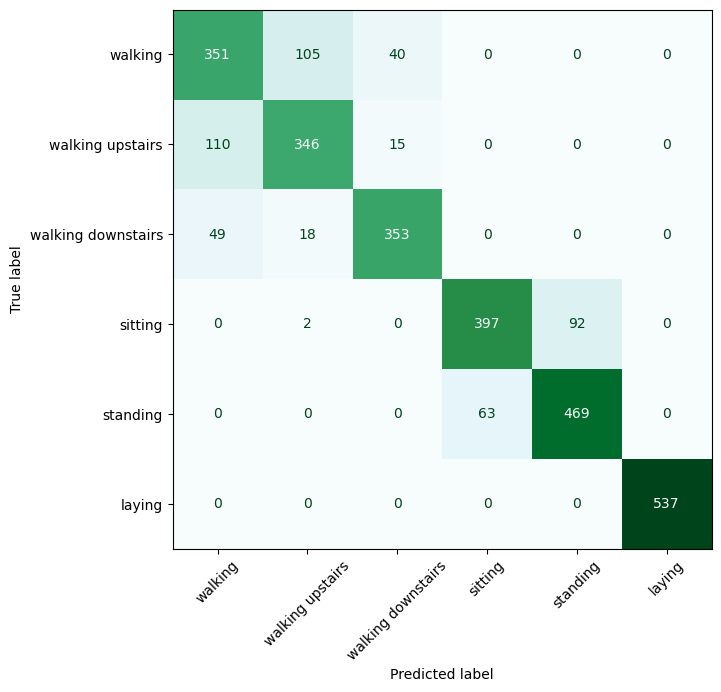

In [16]:
cm = confusion_matrix(Y_test, Y_test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=clf.classes_)
fig, ax = plt.subplots(figsize=(7,7))

disp.plot(cmap='BuGn', colorbar=False, ax=ax)
ax.xaxis.set_ticklabels(activities_labels, rotation=45)

ax.yaxis.set_ticklabels(activities_labels)
plt.show()